In [122]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Seq2seq
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Prédire février 2005 et mars 2005. Entraîner de février 2003 à janvien 2005
df = pd.concat([pd.read_parquet('data/tec_2003.parquet.gzip'), pd.read_parquet('data/tec_2004.parquet.gzip'), pd.read_parquet('data/tec_2005.parquet.gzip')])
df

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
3570,1.041379e+09,59.0,136.0,10.7,2003-01-01 00:02:30,2003,1,1,0,2,30
3571,1.041379e+09,59.0,137.0,10.6,2003-01-01 00:02:30,2003,1,1,0,2,30
3613,1.041379e+09,60.0,143.0,10.0,2003-01-01 00:02:30,2003,1,1,0,2,30
3679,1.041379e+09,62.0,134.0,7.0,2003-01-01 00:02:30,2003,1,1,0,2,30
7679,1.041380e+09,59.0,136.0,10.7,2003-01-01 00:07:30,2003,1,1,0,7,30
...,...,...,...,...,...,...,...,...,...,...,...
21918479,1.136073e+09,59.0,140.0,7.5,2005-12-31 23:52:30,2005,12,31,23,52,30
21918600,1.136073e+09,62.0,141.0,5.3,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30
21923483,1.136073e+09,58.0,140.0,7.9,2005-12-31 23:57:30,2005,12,31,23,57,30


### Manipulation de données

In [4]:
df_siberia = df [(df['gdlat'] >= 56.0) & (df['gdlat'] <= 58.0) & (df['glon'] >= 136.0) & (df['glon'] <= 140.0)].copy()
df_siberia

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
66026,1.041384e+09,57.0,136.0,14.0,2003-01-01 01:17:30,2003,1,1,1,17,30
70328,1.041384e+09,57.0,137.0,13.6,2003-01-01 01:22:30,2003,1,1,1,22,30
74634,1.041384e+09,57.0,137.0,13.5,2003-01-01 01:27:30,2003,1,1,1,27,30
74635,1.041384e+09,57.0,138.0,13.5,2003-01-01 01:27:30,2003,1,1,1,27,30
74673,1.041384e+09,58.0,138.0,13.5,2003-01-01 01:27:30,2003,1,1,1,27,30
...,...,...,...,...,...,...,...,...,...,...,...
21795798,1.136066e+09,56.0,140.0,5.1,2005-12-31 21:52:30,2005,12,31,21,52,30
21795846,1.136066e+09,57.0,140.0,5.0,2005-12-31 21:52:30,2005,12,31,21,52,30
21918433,1.136073e+09,58.0,140.0,7.8,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30


In [5]:
def interpolate_to_2hourly(df, datetime_col, measure_col):
    """
    Interpolate irregular time series data to a regular 2-hourly frequency.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with regular 2-hourly timestamps and interpolated values
    """
    # Ensure datetime column is datetime type
    df = df.copy()
    
    # Create regular hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Set datetime as index
    df = df.set_index(datetime_col)
    
    # Perform linear interpolation
    two_hourly_df = pd.DataFrame(index=two_hourly_index)
    two_hourly_df[measure_col] = np.interp(
        x=two_hourly_index.astype(np.int64) // 10**9,  # Convert to unix timestamp
        xp=df.index.astype(np.int64) // 10**9,
        fp=df[measure_col]
    )
    
    # Reset index to make datetime a column again
    two_hourly_df.reset_index(inplace=True)
    two_hourly_df.rename(columns={'index': datetime_col}, inplace=True)
    
    return two_hourly_df

In [6]:
df_siberia_interpolated = interpolate_to_2hourly(df_siberia, 'datetime', 'tec')
df_siberia_interpolated

,datetime,tec
0,2003-01-01 00:00:00,14.000000
1,2003-01-01 02:00:00,13.600000
2,2003-01-01 04:00:00,16.550000
3,2003-01-01 06:00:00,13.850000
4,2003-01-01 08:00:00,8.601515
...,...,...
13148,2005-12-31 16:00:00,4.200000
13149,2005-12-31 18:00:00,3.343269
13150,2005-12-31 20:00:00,4.312500
13151,2005-12-31 22:00:00,5.175000


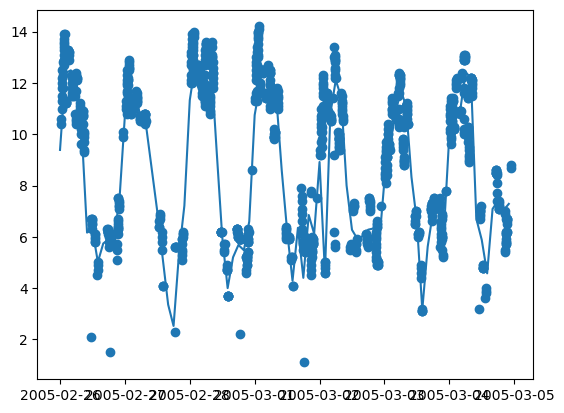

In [13]:
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-03-05')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-03-05')] )
plt.plot(df_siberia_interpolated['datetime'][(df_siberia_interpolated['datetime'] >= '2005-02-26') & (df_siberia_interpolated['datetime'] < '2005-03-05')] , df_siberia_interpolated['tec'][(df_siberia_interpolated['datetime'] >= '2005-02-26') & (df_siberia_interpolated['datetime'] < '2005-03-05')] )


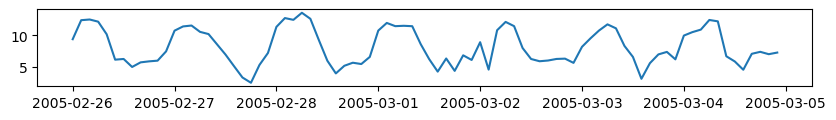

In [14]:
plt.figure(figsize=(10, 1))
plt.plot(df_siberia_interpolated['datetime'][(df_siberia_interpolated['datetime'] >= '2005-02-26') & (df_siberia_interpolated['datetime'] < '2005-03-05')] , df_siberia_interpolated['tec'][(df_siberia_interpolated['datetime'] >= '2005-02-26') & (df_siberia_interpolated['datetime'] < '2005-03-05')] )


In [15]:
# Prédire février 2005 et mars 2005.
# Entraîner de février 2003 à janvien 2005
train = df_siberia_interpolated [(df_siberia_interpolated['datetime'] >= '2003-02-25') & (df_siberia_interpolated['datetime'] < '2005-02-25')] 
test = df_siberia_interpolated [(df_siberia_interpolated['datetime'] >= '2005-02-25') & (df_siberia_interpolated['datetime'] < '2005-03-06')] 


In [16]:
train = train.set_index('datetime')
test = test.set_index('datetime')


In [ ]:
train

,tec
datetime,
2003-02-25 00:00:00,16.952500
2003-02-25 02:00:00,21.050000
2003-02-25 04:00:00,19.183871
2003-02-25 06:00:00,17.016129
2003-02-25 08:00:00,18.300000
...,...
2005-02-24 14:00:00,5.500000
2005-02-24 16:00:00,5.417105
2005-02-24 18:00:00,7.250000


In [ ]:
test

,tec
datetime,
2005-02-25 00:00:00,9.763333
2005-02-25 02:00:00,10.950000
2005-02-25 04:00:00,11.700000
2005-02-25 06:00:00,12.850000
2005-02-25 08:00:00,10.964286
...,...
2005-03-05 14:00:00,5.888095
2005-03-05 16:00:00,7.145238
2005-03-05 18:00:00,6.764286


### SARIMA

In [ ]:
def sarimax_grid_search(data, p_range, d_range, q_range, P_range, D_range, Q_range):
    """
    Perform grid search over SARIMAX parameters (p, d, q) and (P, D, Q).
    
    Parameters:
    -----------
    data : array-like
        Time series data to fit
    p_range : list
        Range of p values to test
    d_range : list
        Range of d values to test
    q_range : list
        Range of q values to test
    P_range : list
        Range of P values to test
    D_range : list
        Range of D values to test
    Q_range : list
        Range of Q values to test
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing results for each parameter combination
    best_params : list
        [(p, d, q), (P, D, Q)] combination with lowest AIC
    """
    
    # Create all possible combinations of parameters
    pdqPDQ = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))
    
    # Initialize results storage
    results = []
    
    # Grid search
    for param in tqdm(pdqPDQ):
        try:
            model = SARIMAX(data,
                            order=(param[0], param[1], param[2]),
                            seasonal_order=(param[3], param[4], param[5], 12))
            model_fit = model.fit(disp=False)
            
            # Store results
            results.append({
                'p': param[0],
                'd': param[1],
                'q': param[2],
                'P': param[3],
                'D': param[4],
                'Q': param[5],
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'hqic': model_fit.hqic,
                'converged': model_fit.mle_retvals['converged']
            })
            
        except Exception as e:
            results.append({
                'p': param[0],
                'd': param[1],
                'q': param[2],
                'P': param[3],
                'D': param[4],
                'Q': param[5],
                'aic': None,
                'bic': None,
                'hqic': None,
                'converged': False,
                'error': str(e)
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters (based on AIC)
    best_params = None
    if not results_df['aic'].isna().all():
        best_idx = results_df['aic'].idxmin()
        best_params = (
            results_df.loc[best_idx, 'p'],
            results_df.loc[best_idx, 'd'],
            results_df.loc[best_idx, 'q'],
            results_df.loc[best_idx, 'P'],
            results_df.loc[best_idx, 'D'],
            results_df.loc[best_idx, 'Q']
        )
    
    return results_df, best_params

In [ ]:
# Define parameter ranges to test
p_range = list(range(0, 2))
d_range = list(range(0, 1))
q_range = list(range(0, 2))
P_range = list(range(0, 2))
D_range = list(range(0, 1))
Q_range = list(range(0, 2))

# Perform grid search
results_df, best_params = sarimax_grid_search(train, p_range, d_range, q_range, P_range, D_range, Q_range)

# Print results
print("\nTop 5 models by AIC:")
print(results_df.sort_values('aic').head())

print("\nBest parameters (p,d,q), (P,D,Q):", best_params)

In [ ]:
'''
Top 5 models by AIC:
    p  d  q  P  D  Q           aic           bic          hqic  converged
15  1  0  1  1  0  1  37171.349492  37206.746093  37183.409485       True
11  1  0  0  1  0  1  37316.904716  37345.221997  37326.552711       True
7   0  0  1  1  0  1  38910.709252  38939.026533  38920.357247       True
14  1  0  1  1  0  0  39873.561959  39901.879239  39883.209953       True
10  1  0  0  1  0  0  40063.671229  40084.909190  40070.907225       True

Best parameters (p,d,q), (P,D,Q): (np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1))
'''

'\nTop 5 models by AIC:\n    p  d  q  P  D  Q           aic           bic          hqic  converged\n15  1  0  1  1  0  1  37171.349492  37206.746093  37183.409485       True\n11  1  0  0  1  0  1  37316.904716  37345.221997  37326.552711       True\n7   0  0  1  1  0  1  38910.709252  38939.026533  38920.357247       True\n14  1  0  1  1  0  0  39873.561959  39901.879239  39883.209953       True\n10  1  0  0  1  0  0  40063.671229  40084.909190  40070.907225       True\n\nBest parameters (p,d,q), (P,D,Q): (np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1))\n'

In [ ]:
# Fit model with best parameters
best_model = SARIMAX(train, order=best_params[:3], seasonal_order=(*best_params[3:], 12)).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary().tables[1])


Best model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7819      0.007    110.588      0.000       0.768       0.796
ma.L1         -0.2211      0.009    -23.951      0.000      -0.239      -0.203
ar.S.L12       0.9897      0.001    776.041      0.000       0.987       0.992
ma.S.L12      -0.6954      0.003   -203.198      0.000      -0.702      -0.689
sigma2         4.0364      0.012    326.981      0.000       4.012       4.061


In [ ]:
predict = best_model.forecast(steps=108)
predict

2005-02-25 00:00:00    10.946223
2005-02-25 02:00:00    13.177240
2005-02-25 04:00:00    13.204225
2005-02-25 06:00:00    13.049724
2005-02-25 08:00:00    10.722506
                         ...    
2005-03-05 14:00:00     4.585172
2005-03-05 16:00:00     4.511375
2005-03-05 18:00:00     6.217623
2005-03-05 20:00:00     5.706438
2005-03-05 22:00:00     6.511442
Freq: 2h, Name: predicted_mean, Length: 108, dtype: float64

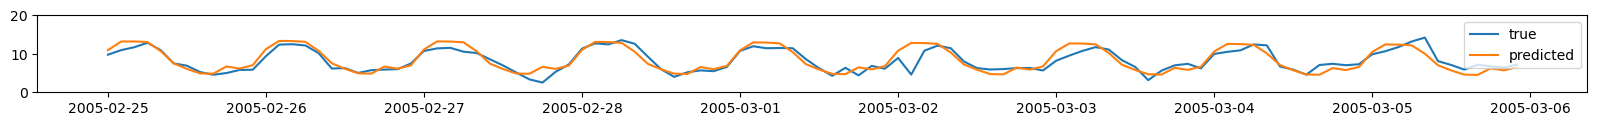

In [ ]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()

### LSTM

In [112]:
train = df_siberia_interpolated [(df_siberia_interpolated['datetime'] >= '2003-02-25') & (df_siberia_interpolated['datetime'] < '2005-02-25')] 
test2 = df_siberia_interpolated [(df_siberia_interpolated['datetime'] >= '2005-02-20') & (df_siberia_interpolated['datetime'] < '2005-03-06')] 

In [113]:
train = train.set_index('datetime')
test2 = test2.set_index('datetime')
sequence_length = 50
test2 = test2[len(test2) - len(test) - sequence_length:]

In [114]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [38]:
num_lstm_layers = 2
dropout_rate = 0.2
batch_size = 48
epochs = 500
validation_split = 0.05
input_dim = 1
output_dim = 1

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(units=output_dim, activation='linear'))

model.compile(optimizer='Adam', loss='mae', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

2024-12-23 10:08:51.006876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0839 - mae: 0.0839 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 2/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 3/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 4/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 5/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 6/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0605 - mae: 0.0605 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 7/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 8/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0560 - mae: 0.0560 - val_loss: 0.0494 - val_mae: 0.0494
Epoch 9/500
173/173 ━━━━━━━━━━━━━━━━━━━

In [62]:
model.save('lstm/lstm_model.keras')

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(test2)

sequence_length = 50
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1391 - mae: 0.1391
Loss on test data: 0.14032581448554993
MAE on test data: 0.14032581448554993


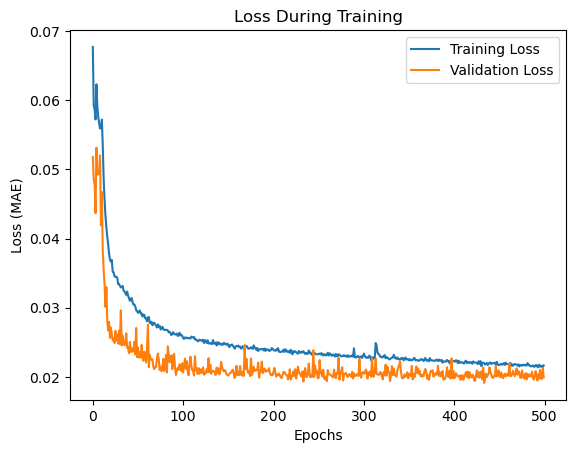

In [116]:
# Visualisation sur le dataset de test
loss, mae = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Loss on test data: {loss}")
print(f"MAE on test data: {mae}")

# Visualisation de l'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


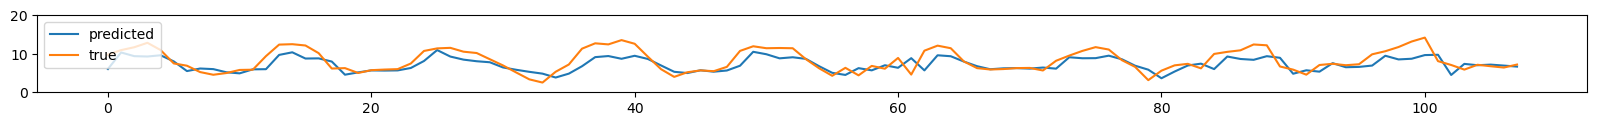

In [117]:
unscaled_lstm_prediction = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(unscaled_lstm_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(lstm_predictions, label='predicted')
plt.plot(unscaled_y_test, label='true')
plt.legend()

### Seq2Seq

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Hyperparamètres
learning_rate = 0.01
lambda_l2_reg = 0.003
hidden_dim = 64
num_lstm_layers = 1  
gradient_clipping = 2.5
num_input_signals = 1
num_output_signals = 1

model = Sequential()

model.add(LSTM(
    units=hidden_dim, 
    activation='relu', 
    input_shape=(X_train.shape[1], num_input_signals), 
    return_sequences=False, 
    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2_reg)
))

model.add(Dense(units=num_output_signals))

optimizer = Adam(learning_rate=learning_rate, clipvalue=gradient_clipping)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=48,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0094 - mae: 0.0697 - val_loss: 0.0079 - val_mae: 0.0747
Epoch 2/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0057 - mae: 0.0571 - val_loss: 0.0055 - val_mae: 0.0618
Epoch 3/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0050 - mae: 0.0539 - val_loss: 0.0036 - val_mae: 0.0435
Epoch 4/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0037 - mae: 0.0424 - val_loss: 0.0060 - val_mae: 0.0637
Epoch 5/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0027 - mae: 0.0358 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 6/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0017 - val_mae: 0.0292
Epoch 7/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 8/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0020 - val_mae: 0.0326
Epoch 9/1500
146/146 ━━━━━━━━━━━

In [125]:
model.save('seq2seq/seq2seq_model.keras')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


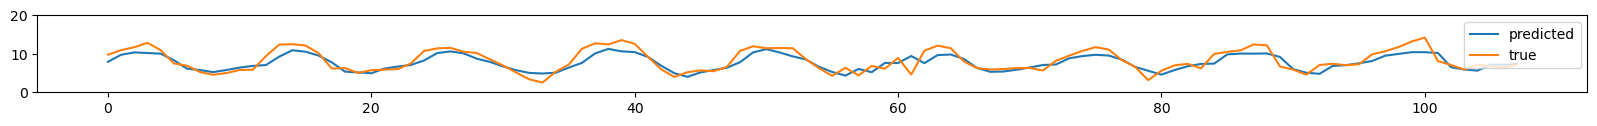

In [129]:
unscaled_seq_prediction = model.predict(X_test)
seq2seq_predictions = scaler.inverse_transform(unscaled_seq_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(lstm_predictions, label='predicted')
plt.plot(unscaled_y_test, label='true')
plt.legend()